In [1]:
1*2

2

In [2]:
import importlib
def rl():
    importlib.reload(Di)

In [3]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [6]:
import torch
import gpytorch

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import Di

In [7]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

In [8]:
env = env_list[5]
print(env)

NaCl


In [9]:
df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

In [10]:
ids = list(df.columns[3:])

In [11]:
env + '_matsui_geno_t.pt'

'NaCl_matsui_geno_t.pt'

In [12]:
geno_t = torch.load(env + '_matsui_geno_t.pt')

In [13]:
geno_t

tensor([[1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [14]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [15]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

In [16]:
pheno = pheno.set_index('geno')

In [17]:
pheno = pheno.loc[ids]

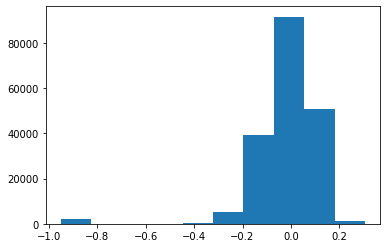

In [18]:
plt.hist(pheno.pheno)
plt.show()

### Set up

In [19]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 8 GPUs.


In [20]:
output_device = torch.device('cuda:0')

### Data

In [21]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

In [22]:
np.random.seed(100)

In [23]:
sub = np.random.choice(inds_sub, 10000)

sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5000)

In [24]:
train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

In [25]:
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

### Define functions

In [26]:
def d(geno1, geno2):
  """build distance tensor between two sets of genotypes
  geno1, geno2: n x L, m x L torch tensors
  
  """
  geno1_h0 = 1.*(geno1 == 0.)
  geno1_h1 = 1.*(geno1 == 2.)
  geno2_h0 = 1.*(geno2 == 0.)
  geno2_h1 = 1.*(geno2 == 2.)
  S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
  S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
  D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
  D1 = L - S1 - S2 - D2

  return torch.stack((S1, S2, D1, D2))


In [27]:
def k(log_lda, log_eta, dvec):
    """
    log_lda, log_eta -- torch tensors
    dvec -- 4 x n x m torch tensor
    """
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    return (((1 + lda + eta)**(dvec[1] - L/2))
          *((1 - lda + eta)**dvec[3])
          *((1 + eta)**(dvec[0] - L/2)) 
          * (1-eta)**dvec[2])


In [31]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan


class DiKernel(gpytorch.kernels.Kernel):
  """Diploid kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                lda_prior=None, lda_constraint=None, 
                eta_prior=None, eta_constraint=None,
                **kwargs):
      super().__init__(**kwargs)

      # register the raw parameter
      self.register_parameter(
          name='raw_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      self.register_parameter(
          name='raw_eta', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      # set the parameter constraint to be positive, when nothing is specified
      if lda_constraint is None:
          lda_constraint = LessThan(upper_bound=0.)

      if eta_constraint is None:
          eta_constraint = LessThan(upper_bound=0.)

      # register the constraint
      self.register_constraint("raw_lda", lda_constraint)
      self.register_constraint("raw_eta", eta_constraint)

      
  # now set up the 'actual' paramter
  @property
  def lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_lda_constraint.transform(self.raw_lda)

  @property
  def eta(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_eta_constraint.transform(self.raw_eta)

  @lda.setter
  def lda(self, value):
      return self._set_lda(value)

  @eta.setter
  def eta(self, value):
      return self._set_eta(value)

  def forward(self, x1, x2, **params):
      diff = d(x1, x2)
      K = k(self.lda, self.eta, diff)
      return K
      

    
class DiGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            DiKernel(), device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

In [32]:
def train_model(model, likelihood, train_x, train_y, training_iter=300, lr=.05):
    losses = []
    
    """fitting hyperparameters of model by maximizing marginal log likelihood"""
    # Use the adam optimizer, this includes GaussianLikelihood parameters
    optimizer = torch.optim.AdamW(model.parameters(), lr)


    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
      if i%20==0:
        print(i)
      else: pass
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(train_x)
      # Calc loss and backprop gradients
      loss = -mll(output, train_y)
      loss.backward()
      losses.append(loss.item())    
      optimizer.step()
      del loss
    return losses

### Test Parallel

In [33]:
ker = DiKernel().cuda()
ker.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
ker.raw_eta = torch.nn.Parameter(torch.tensor(-12.))

In [34]:
ker(train_x).numpy()

array([[1.12790801, 0.26316077, 0.26134664, ..., 0.30165121, 0.24336607,
        0.25346414],
       [0.26316077, 1.35494568, 0.25834609, ..., 0.21282889, 0.25131504,
        0.29399075],
       [0.26134664, 0.25834609, 1.18211291, ..., 0.30208467, 0.22085312,
        0.31230808],
       ...,
       [0.30165121, 0.21282889, 0.30208467, ..., 0.97844272, 0.25564261,
        0.24782828],
       [0.24336607, 0.25131504, 0.22085312, ..., 0.25564261, 0.71682001,
        0.34293459],
       [0.25346414, 0.29399075, 0.31230808, ..., 0.24782828, 0.34293459,
        1.13549667]])

In [46]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DiGPModel(train_x, train_y, likelihood)
model.covar_module.module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model = model.to(output_device).double()

In [47]:
model.covar_module(train_x).numpy()

array([[1.12791385, 0.26322096, 0.26140018, ..., 0.30171057, 0.24341216,
        0.25351248],
       [0.26322096, 1.35496337, 0.25840231, ..., 0.21287411, 0.25137328,
        0.29405676],
       [0.26140018, 0.25840231, 1.18212142, ..., 0.30214379, 0.22089751,
        0.31237305],
       ...,
       [0.30171057, 0.21287411, 0.30214379, ..., 0.9784418 , 0.25568771,
        0.24787775],
       [0.24341216, 0.25137328, 0.22089751, ..., 0.25568771, 0.71680975,
        0.34299273],
       [0.25351248, 0.29405676, 0.31237305, ..., 0.24787775, 0.34299273,
        1.13550287]])

In [48]:
output = model(train_x)

In [49]:
output.covariance_matrix

tensor([[1.1279, 0.2632, 0.2614,  ..., 0.3017, 0.2434, 0.2535],
        [0.2632, 1.3550, 0.2584,  ..., 0.2129, 0.2514, 0.2941],
        [0.2614, 0.2584, 1.1821,  ..., 0.3021, 0.2209, 0.3124],
        ...,
        [0.3017, 0.2129, 0.3021,  ..., 0.9784, 0.2557, 0.2479],
        [0.2434, 0.2514, 0.2209,  ..., 0.2557, 0.7168, 0.3430],
        [0.2535, 0.2941, 0.3124,  ..., 0.2479, 0.3430, 1.1355]],
       device='cuda:0', dtype=torch.float64, grad_fn=<MatmulBackward>)

In [50]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

likelihood.noise_covar.raw_noise tensor([0.], device='cuda:0', dtype=torch.float64)
mean_module.constant tensor([0.], device='cuda:0', dtype=torch.float64)
covar_module.module.raw_lda tensor(-8., device='cuda:0', dtype=torch.float64)
covar_module.module.raw_eta tensor(-12., device='cuda:0', dtype=torch.float64)


In [51]:
losses = train_model(model, likelihood, train_x, train_y, training_iter=400, lr=.02)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


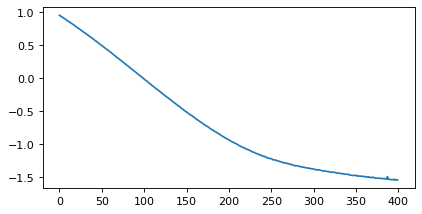

In [52]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

In [53]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu().detach().numpy()

y_test = test_y.detach().cpu().numpy()

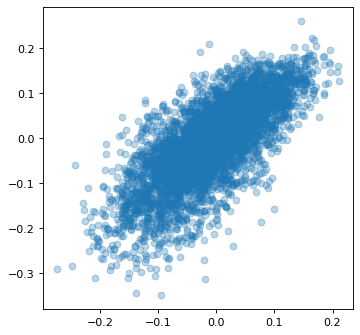

r2 = 0.559097
R2 = 0.554530
mse = 0.003703


In [54]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### Test Di

In [55]:
suball = np.concatenate([sub, sub_t])

In [56]:
import Di
Di.set_params(geno_t[suball])

In [57]:
train_n = torch.tensor(range(10000)).to(output_device)

In [58]:
ker2 = Di.DiKernel().cuda()
ker2.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
ker2.raw_eta = torch.nn.Parameter(torch.tensor(-12.))

In [59]:
ker2(train_n, train_n).numpy()

array([[1.12790801, 0.26316077, 0.26134664, ..., 0.30165121, 0.24336607,
        0.25346414],
       [0.26316077, 1.35494568, 0.25834609, ..., 0.21282889, 0.25131504,
        0.29399075],
       [0.26134664, 0.25834609, 1.18211291, ..., 0.30208467, 0.22085312,
        0.31230808],
       ...,
       [0.30165121, 0.21282889, 0.30208467, ..., 0.97844272, 0.25564261,
        0.24782828],
       [0.24336607, 0.25131504, 0.22085312, ..., 0.25564261, 0.71682001,
        0.34293459],
       [0.25346414, 0.29399075, 0.31230808, ..., 0.24782828, 0.34293459,
        1.13549667]])

In [60]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.DiGPModel(train_n, train_y, likelihood).to(output_device).double()

model.covar_module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))


In [61]:
losses = Di.train_model(model, likelihood, train_n, train_y, training_iter=400, lr=0.02)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


In [62]:
test_n = torch.tensor(range(10000, 15000)).to(output_device)

In [63]:
test_n = test_n.cuda()

model.eval()
f_preds = model(test_n)

f_mean = f_preds.mean.cpu().detach().numpy()

y_test = test_y.detach().cpu().numpy()

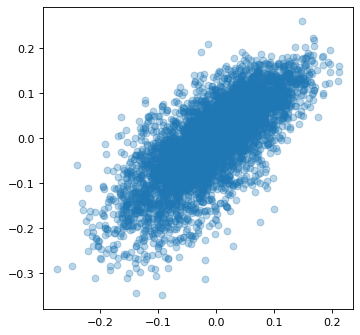

r2 = 0.558857
R2 = 0.554448
mse = 0.003704


In [64]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

In [260]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DiGPModel(train_x, train_y, likelihood)
model = model.to(output_device)

In [261]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [262]:
test_x = test_x.cuda()

In [263]:
model.eval()
f_preds = model(test_x)

In [264]:
f_mean = f_preds.mean.cpu()

In [265]:
f_true = test_y.cpu().numpy()

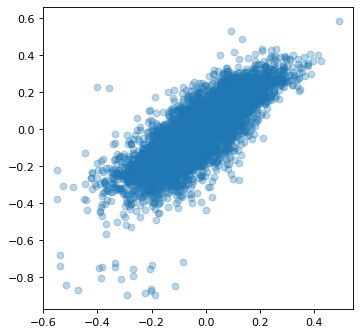

r2 = 0.633117
R2 = 0.629726
mse = 0.011208


In [266]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), f_true, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), f_true)[0]**2)
print('R2 = %f'%r2(f_true, f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), f_true))